In [1]:
# pip install astral skforecast feature_engine plotly lightgbm shap

In [2]:
# Import libraries:

import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 8})
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import calculate_lag_autocorrelation, plot_residuals
from skforecast.metrics import calculate_coverage
import shap

c:\Users\pmlegeren\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## Datos

In [3]:
data_raw = fetch_dataset(name='vic_electricity', raw=True)
data_raw.info()

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [4]:
data = data_raw.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(6)


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
2011-12-31 15:30:00,3865.597244,20.25,2012-01-01,True


Compruebo que están todos los valores, que el índice temporal está lleno

In [5]:
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Índice completo: {is_index_complete}")
print(f"Filas con valores faltantes: {data.isnull().any(axis=1).mean()}")

print(f'El rango de fechas es de {start_date} a {end_date}')
print(f'Hay un total de {data.shape[0]} observaciones con una frecuencia de {data.index.freq}')

Índice completo: True
Filas con valores faltantes: 0.0
El rango de fechas es de 2011-12-31 13:00:00 a 2014-12-31 12:30:00
Hay un total de 52608 observaciones con una frecuencia de <30 * Minutes>


Como la frecuencia es de 30 mins. para obtener una frecuencia horaria hay que agrupar los valores. Para ello se elige closed='left' y label='right' ya que para la estimación de las 14:00 usas los intervalos 13:00-13:30 y 13:30-14:00. No puedes usar el valor de 14:00-14:30 ya que se estarías usando un dato del futuro.

In [6]:
data = data.drop(columns="Date")
data = (
    data.resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean", "Temperature": "mean", "Holiday": "mean",
    })
)
data

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


Como se puede ver, empieza a las 14:00 de un día y acaba a las 13:00 de otro. Elimino las 10 primeras observaciones para que empiece a las 00:00 de un día y las 13 últimas para que acabe a las 00:00.

In [7]:
data = data.loc['2012-01-01 00:00:00':'2014-12-30 23:00:00', :].copy()

Divido los datos en los conjuntos de train, test y validacion

In [8]:
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_val = data.loc[end_train:end_validation, :].copy()
data_test = data.loc[end_validation:, :].copy()

In [9]:
total = len(data)
train_len = len(data_train)
val_len = len(data_val)
test_len = len(data_test)

print(f"Train: {train_len/total:.2%}")
print(f"Validación: {val_len/total:.2%}")
print(f"Test: {test_len/total:.2%}")

Train: 66.76%
Validación: 30.50%
Test: 2.74%


## Gráfico

Paso a ver gráficamente los datos, para ello eje y la demanda y eje x una línea temporal.

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Demand'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Demand'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Demand'], mode='lines', name='Test'))
fig.update_layout(
    title = 'Demanda horaria', xaxis_title = "Fecha", yaxis_title = "Demanda",
    width = 800, height = 500, margin = dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Se puede observar como hay un pico estacional alrededor de julio y como entre enero y el mes de marzo existen picos muy concretos y muy intensos de demanda

## Estacionalidades

Para poder ver más en detalle la serie, se puede hacer un zoom en el gráfico. Al tener los datos con una frecuencia horaria nos permite obtener picos a niveles diario, para ello haremos zoom mensual, semanal y diario.

C:\Users\pmlegeren\AppData\Local\Temp\ipykernel_1780\1238252064.py:31: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



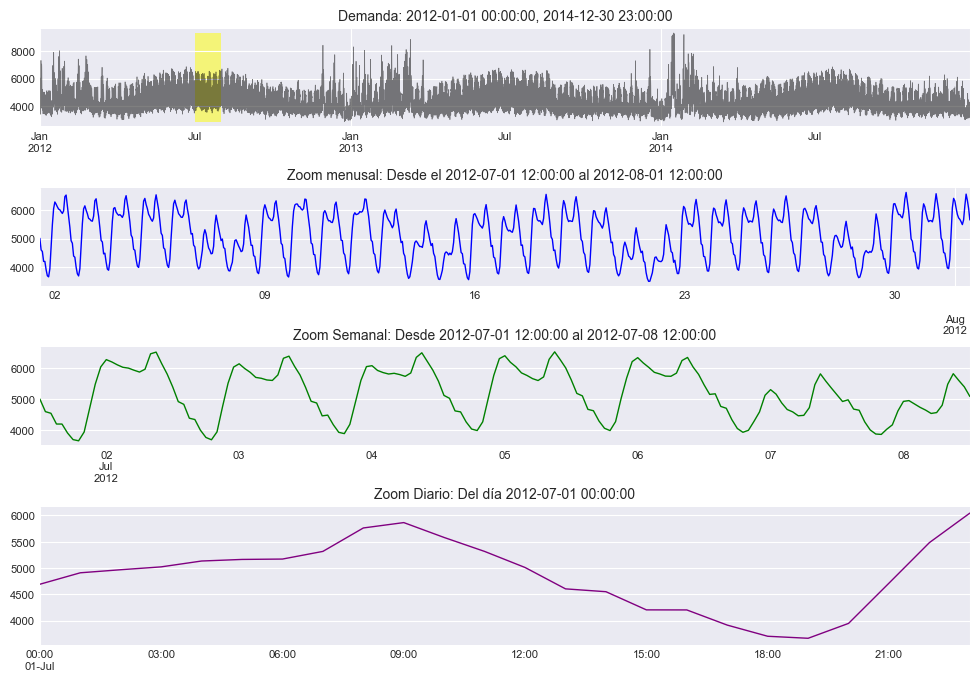

In [11]:
zoom = ('2012-07-01 12:00:00', '2012-08-01 12:00:00')              
weekly_zoom = ('2012-07-01 12:00:00', '2012-07-08 12:00:00')       
daily_zoom = ('2012-07-01 00:00:00', '2012-07-01 23:59:59')        

fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(nrows=16, ncols=1, hspace=1.2, wspace=0)

main_ax = fig.add_subplot(grid[:3, :])
data.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = data.Demand.min()
max_y = data.Demand.max()
main_ax.fill_between(zoom, min_y, max_y, facecolor='yellow', alpha=0.5, zorder=0)
main_ax.set_title(f'Demanda: {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')

zoom_ax = fig.add_subplot(grid[4:7, :])
data.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Zoom menusal: Desde el {zoom[0]} al {zoom[1]}', fontsize=10)
zoom_ax.set_xlabel('')

week_ax = fig.add_subplot(grid[8:11, :])
data.loc[weekly_zoom[0]: weekly_zoom[1]].Demand.plot(ax=week_ax, color='green', linewidth=1)
week_ax.set_title(f'Zoom Semanal: Desde {weekly_zoom[0]} al {weekly_zoom[1]}', fontsize=10)
week_ax.set_xlabel('')

day_ax = fig.add_subplot(grid[12:, :])
data.loc[daily_zoom[0]: daily_zoom[1]].Demand.plot(ax=day_ax, color='purple', linewidth=1)
day_ax.set_title(f'Zoom Diario: Del día {daily_zoom[0]}', fontsize=10)
day_ax.set_xlabel('')

plt.tight_layout()
plt.show()

El grafico semanal permite corroborar lo que ya se podría intuir en el mensual, los fines de semana la demanda es mucho menor que el resto de días. Entrando con algo más de detalle podemos observar que diariamente existen dos picos: uno alrededor de las 9 de la mañana y otro al final del día.

Para poder comprobar esta hipótesis de que existen distintas estacionalidades: diarias, semanales, mensuales, realizo gráficos de estacionalidad para comprobar cada una.

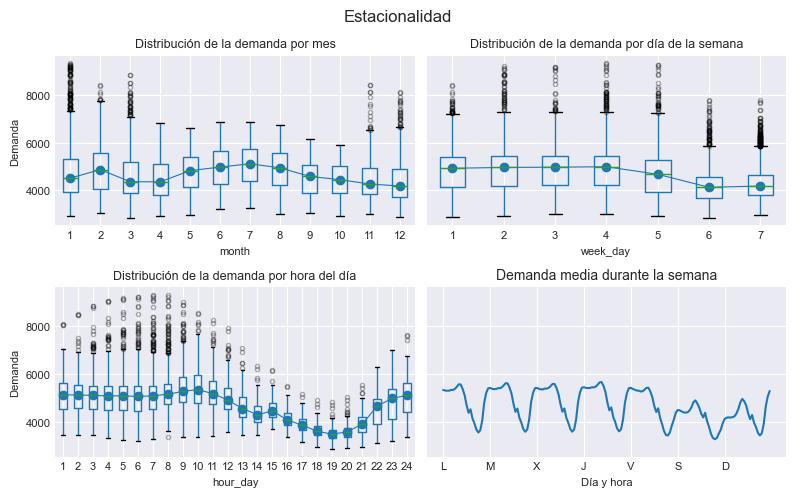

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Demanda mensual
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Demanda')
axs[0].set_title('Distribución de la demanda por mes', fontsize=9)

# Demanda por día de la semana
data['week_day'] = data.index.day_of_week + 1  # para tener los días de la semana del 1 al 7
data.boxplot(column='Demand', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Demanda')
axs[1].set_title('Distribución de la demanda por día de la semana', fontsize=9)

# Demanda por hora del día
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Demanda')
axs[2].set_title('Distribución de la demanda por hora del día', fontsize=9)

# Demanda media por hora y día de la semana
mean_day_hour = data.groupby(["week_day", "hour_day"])["Demand"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title = "Demanda media durante la semana",
    xticks = [i * 24 for i in range(7)], 
    xticklabels = ["L", "M", "X", "J", "V", "S", "D"], xlabel = "Día y hora", ylabel = "Nivel de demanda"
)
axs[3].title.set_size(10)

fig.suptitle("Estacionalidad", fontsize=12)
fig.tight_layout()


Efectivamente en estos gráficos se pueden ir comprobando una a una las suposiciones de antes:
- A nivel mensual existen picos muy intensos pero dispersos (outliers) en los meses de enero a marzo y existe una tendencia a aumentar la demanda en julio.
- A nivel semanal, los sábados y domingos son los días con una menor demanda de la semana.
- A nivel diario, existe una subida entorno a las 9-10 de la mañana y una bajada drástica sobre las 18-19.

## Gráficos de auto-correlación

Al tratarse de series temporales, una buena forma de tratar de entender su comportamiento es con el estudio de sus gráficos de correlación.

El ACF mide la relación entre la serie y sus "lags" que son sus valores rezagados. El PACF es parecido solo que mide esta relación eliminando los valores intermedios. 

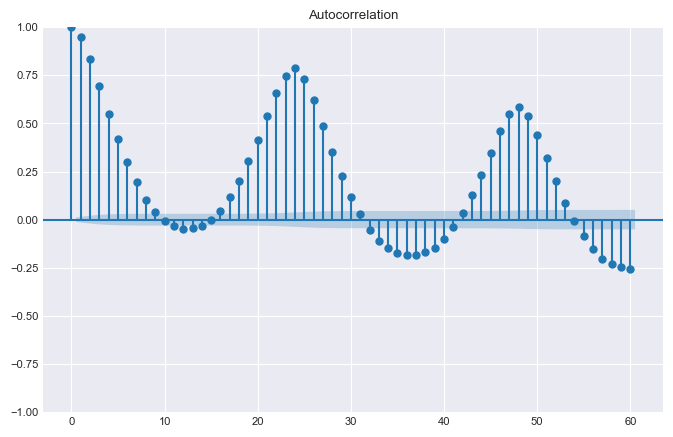

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(data['Demand'], ax=ax, lags=60)
plt.show()

Podemos obsevar que hay picos claros y recurrentes cada 24 lags aproximadamente, lo que sugiere que existe un comportamiento cíclico diario (cada 24 horas). También se ve como en el lag 1, la autocorrelación es casi de 1 por lo que hay una fuerte dependencia del valor justo anterior,

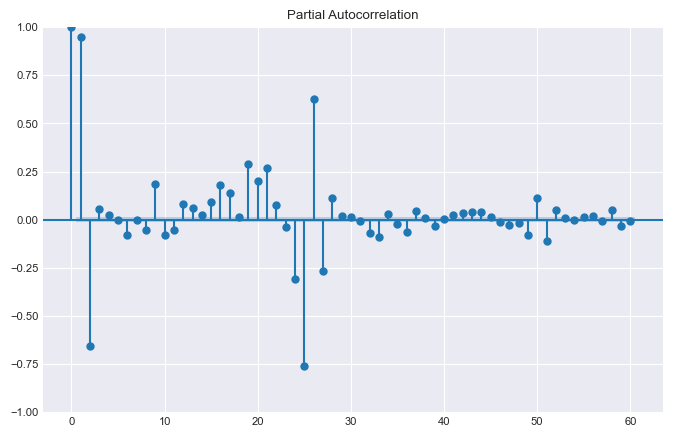

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_pacf(data['Demand'], ax=ax, lags=60)
plt.show()

En este caso podemos observar una autocorrelación parcial de casi 1 para el lag 1 (al igual que en el caso anterior). También podemos ver como existen altos valores en los lags cercanos al lag 24 lo que es una señal fuerte de estacionalidad diaria.

Para comprobar lo anterior, y poder ver los valores tanto de autocorrelación (ACF) como autocorrelación parcial (PACF), obtendré los 10 lags con mayor valor absoluto de PACF ya que en el ACF es bastante más claro

In [15]:
calculate_lag_autocorrelation(
    data = data['Demand'], n_lags = 60, sort_by = "partial_autocorrelation_abs"
).head(10)

,lag,partial_autocorrelation_abs,partial_autocorrelation,autocorrelation_abs,autocorrelation
0,1,0.949526,0.949526,0.949490,0.949490
1,25,0.761400,-0.761400,0.731620,0.731620
2,2,0.657961,-0.657961,0.836792,0.836792
3,26,0.634868,0.634868,0.622458,0.622458
4,24,0.308085,-0.308085,0.785622,0.785622
5,19,0.291113,0.291113,0.302308,0.302308
6,27,0.281261,-0.281261,0.488351,0.488351
7,21,0.269274,0.269274,0.537173,0.537173
8,20,0.201192,0.201192,0.414709,0.414709
9,9,0.184975,0.184975,0.037677,0.037677


Efectivamente los valores cercanos a 24 están entre los primeros lo que sugiere que la serie tiene una estacionalidad diaria. También los primeros lags (1 y 2) demuestran la fuerte relación con los valores previos.

Teniendo esto en cuenta se podría decir que un model autorregresivo sea la mejor opción.

## Modelos

Como no sé con exactitud cuál es el mejor modelo, hago uno de base para contrastar si compensa implementar algún modelo más complejo. El modelo más sencillo en este caso es usar el dato del día anterior (sabiendo la importancia que tiene el lag anterior)

In [16]:
forecaster = ForecasterEquivalentDate(
    offset = pd.DateOffset(days=1), n_offsets = 1
)

forecaster.fit(y=data.loc[:end_validation, 'Demand'])

In [17]:
cv = TimeSeriesFold(
    steps= 24, initial_train_size = len(data.loc[:end_validation]), refit= False
)

metric_baseline, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'],cv = cv, metric = 'mean_absolute_error'
)

metric_baseline

100%|██████████| 30/30 [00:00<00:00, 439.38it/s]


,mean_absolute_error
0,308.375272


Una vez se tiene una métrica de referencia, paso a probar distintos modelos. El primero es un LGBMRegressor, usa la demanda de las últimas 24 horas y la media móvil de los últimos 3 días. 

In [18]:
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)

forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(random_state=15926, verbose=-1), lags = 24, window_features = window_features
)

forecaster.fit(y=data.loc[:end_validation, 'Demand'])

metric_lgbm, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'], cv = cv, metric = 'mean_absolute_error', verbose = False
)

100%|██████████| 30/30 [00:01<00:00, 29.54it/s]


In [19]:
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Demand'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real vs prediction en test",
    xaxis_title="Fecha",
    yaxis_title="Demanda",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.01, xanchor="left", x=0)
)
fig.show()

In [20]:
metric_lgbm

,mean_absolute_error
0,225.521306


Como podemos ver el valor del MAE es más bajo que el anterior modelo lo que indica que este modelo es mejor que el baseline.

El anterior modelo solo usa variables "internas" por lo que es de suponer que mejorará el rendimiento si se le añaden variables externas que le aporten valor. Al tratarse de demanda de energía y habiendo visto las estacionalidades, se probarán con variables relacionadas con la fecha, con la luz del sol, con las vacaciones y con la temperatura.

In [21]:
features_to_extract = [
    'month', 'week', 'day_of_week', 'hour'
]
calendar_transformer = DatetimeFeatures(
    variables = 'index', features_to_extract = features_to_extract, drop_original = True,
)
calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

In [22]:
location = LocationInfo(
    latitude  = -37.8, longitude = 144.95, timezone  = 'Australia/Melbourne'
)

sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise']
    for date in data.index
]

sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset']
    for date in data.index
]

sunrise_hour = pd.Series(sunrise_hour, index=data.index).dt.round("h").dt.hour
sunset_hour = pd.Series(sunset_hour, index=data.index).dt.round("h").dt.hour

sun_light_features = pd.DataFrame({
    'sunrise_hour': sunrise_hour, 'sunset_hour': sunset_hour
})
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features["is_daylight"] = np.where( 
    (data.index.hour >= sun_light_features["sunrise_hour"]) & (data.index.hour < sun_light_features["sunset_hour"]), 1, 0
)

In [23]:
holiday_features = data[['Holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['Holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['Holiday'].shift(-24)

In [24]:
wf_transformer = WindowFeatures(
    variables = ["Temperature"], window = ["1D", "7D"], functions = ["mean", "max", "min"], freq = "h"
)
temp_features = wf_transformer.fit_transform(data[['Temperature']])

In [25]:
assert all(calendar_features.index == sun_light_features.index)
assert all(calendar_features.index == temp_features.index)
assert all(calendar_features.index == holiday_features.index)
exogenous_features = pd.concat([
    calendar_features, sun_light_features, temp_features, holiday_features
], axis=1)

In [26]:
exogenous_features = exogenous_features.iloc[7 * 24:, :]
exogenous_features = exogenous_features.iloc[:-24, :]
exogenous_features.head(3)

,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,Temperature,Temperature_window_1D_mean,Temperature_window_1D_max,Temperature_window_1D_min,Temperature_window_7D_mean,Temperature_window_7D_max,Temperature_window_7D_min,Holiday,holiday_previous_day,holiday_next_day
Time,,,,,,,,,,,,,,,,,,
2012-01-08 00:00:00,1,1,6,0,6,21,15,0,20.575,24.296875,29.0,19.875,23.254018,39.525,14.35,0,0.0,0.0
2012-01-08 01:00:00,1,1,6,1,6,21,15,0,22.500,24.098958,29.0,19.875,23.215774,39.525,14.35,0,0.0,0.0
2012-01-08 02:00:00,1,1,6,2,6,21,15,0,25.250,23.923958,29.0,19.875,23.173214,39.525,14.35,0,0.0,0.0


Hay ciertos valores que se tienen como numéricos ordinales pero realmente no son así (día de la semana, mes del año, hora del día...) sino que son cíclicas por lo que se transforman en funciones de seno y coseno. 

In [27]:
features_to_encode = [
    "month", "week", "day_of_week", "hour", "sunrise_hour", "sunset_hour",
]

max_values = {
    "month": 12, "week": 52, "day_of_week": 6, "hour": 24, "sunrise_hour": 24, "sunset_hour": 24,
}

cyclical_encoder = CyclicalFeatures(
    variables = features_to_encode, max_values = max_values, drop_original = False
)

exogenous_features = cyclical_encoder.fit_transform(exogenous_features)
exogenous_features.head(3)

,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,Temperature,Temperature_window_1D_mean,...,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,sunrise_hour_sin,sunrise_hour_cos,sunset_hour_sin,sunset_hour_cos
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-08 00:00:00,1,1,6,0,6,21,15,0,20.575,24.296875,...,0.120537,0.992709,-2.449294e-16,1.0,0.000000,1.000000,1.0,6.123234e-17,-0.707107,0.707107
2012-01-08 01:00:00,1,1,6,1,6,21,15,0,22.500,24.098958,...,0.120537,0.992709,-2.449294e-16,1.0,0.258819,0.965926,1.0,6.123234e-17,-0.707107,0.707107
2012-01-08 02:00:00,1,1,6,2,6,21,15,0,25.250,23.923958,...,0.120537,0.992709,-2.449294e-16,1.0,0.500000,0.866025,1.0,6.123234e-17,-0.707107,0.707107


Una vez creadas las variables externas, para tener en cuenta la posible interacción entre ellas se crean variables polinómicas.

In [28]:
transformer_poly = PolynomialFeatures(
    degree = 2, interaction_only = True, include_bias = False
).set_output(transform="pandas")

poly_cols = [
    'month_sin', 'month_cos', 'week_sin', 'week_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'sunrise_hour_sin',
    'sunrise_hour_cos', 'sunset_hour_sin', 'sunset_hour_cos', 'daylight_hours', 'is_daylight', 'holiday_previous_day', 'holiday_next_day',
    'Temperature_window_1D_mean', 'Temperature_window_1D_min', 'Temperature_window_1D_max', 'Temperature_window_7D_mean', 
    'Temperature_window_7D_min', 'Temperature_window_7D_max', 'Temperature', 'Holiday'
]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols])
poly_features = poly_features.drop(columns=poly_cols)

poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")

assert all(poly_features.index == exogenous_features.index)

exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)
exogenous_features.head(3)

,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,Temperature,Temperature_window_1D_mean,...,poly_Temperature_window_7D_mean__Temperature_window_7D_min,poly_Temperature_window_7D_mean__Temperature_window_7D_max,poly_Temperature_window_7D_mean__Temperature,poly_Temperature_window_7D_mean__Holiday,poly_Temperature_window_7D_min__Temperature_window_7D_max,poly_Temperature_window_7D_min__Temperature,poly_Temperature_window_7D_min__Holiday,poly_Temperature_window_7D_max__Temperature,poly_Temperature_window_7D_max__Holiday,poly_Temperature__Holiday
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-08 00:00:00,1,1,6,0,6,21,15,0,20.575,24.296875,...,333.695156,919.115056,478.451417,0.0,567.18375,295.25125,0.0,813.226875,0.0,0.0
2012-01-08 01:00:00,1,1,6,1,6,21,15,0,22.500,24.098958,...,333.146354,917.603460,522.354911,0.0,567.18375,322.87500,0.0,889.312500,0.0,0.0
2012-01-08 02:00:00,1,1,6,2,6,21,15,0,25.250,23.923958,...,332.535625,915.921295,585.123661,0.0,567.18375,362.33750,0.0,998.006250,0.0,0.0


In [29]:
exog_features = []

exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
exog_features.extend(exogenous_features.filter(regex='^Temperature_.*').columns.tolist())
exog_features.extend(exogenous_features.filter(regex='^Holiday_.*').columns.tolist())
exog_features.extend(['Temperature', 'Holiday'])

Estas variables exógenas se añaden a los datos originales

In [30]:
data = data[['Demand']].merge(
    exogenous_features[exog_features], left_index = True, right_index = True, how = 'inner'
)
data = data.astype('float32')

data_train = data.loc[: end_train, :].copy()
data_val = data.loc[end_train:end_validation, :].copy()
data_test = data.loc[end_validation:, :].copy()

Ya se puede observar como sería el dataset completo con las nuevas variables introducidas.

In [31]:
data

,Demand,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,sunrise_hour_sin,...,poly_sunrise_hour_cos__sunset_hour_cos,poly_sunset_hour_sin__sunset_hour_cos,Temperature_window_1D_mean,Temperature_window_1D_max,Temperature_window_1D_min,Temperature_window_7D_mean,Temperature_window_7D_max,Temperature_window_7D_min,Temperature,Holiday
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-08 00:00:00,4205.138184,5.000000e-01,0.866025,0.120537,0.992709,-2.449294e-16,1.0,0.000000,1.000000,1.0,...,4.329780e-17,-0.5,24.296875,29.000000,19.875,23.254019,39.525002,14.35,20.575001,0.0
2012-01-08 01:00:00,4288.632812,5.000000e-01,0.866025,0.120537,0.992709,-2.449294e-16,1.0,0.258819,0.965926,1.0,...,4.329780e-17,-0.5,24.098959,29.000000,19.875,23.215775,39.525002,14.35,22.500000,0.0
2012-01-08 02:00:00,4361.893555,5.000000e-01,0.866025,0.120537,0.992709,-2.449294e-16,1.0,0.500000,0.866025,1.0,...,4.329780e-17,-0.5,23.923958,29.000000,19.875,23.173214,39.525002,14.35,25.250000,0.0
2012-01-08 03:00:00,4387.540527,5.000000e-01,0.866025,0.120537,0.992709,-2.449294e-16,1.0,0.707107,0.707107,1.0,...,4.329780e-17,-0.5,23.839582,29.000000,19.875,23.135118,39.525002,14.35,26.424999,0.0
2012-01-08 04:00:00,4386.633789,5.000000e-01,0.866025,0.120537,0.992709,-2.449294e-16,1.0,0.866025,0.500000,1.0,...,4.329780e-17,-0.5,23.760416,29.000000,19.875,23.097918,39.525002,14.35,27.049999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-29 19:00:00,3236.444092,-2.449294e-16,1.000000,0.120537,0.992709,0.000000e+00,1.0,-0.965926,0.258819,1.0,...,4.329780e-17,-0.5,19.125000,25.700001,14.050,18.940475,31.100000,11.05,13.900000,0.0
2014-12-29 20:00:00,3457.501709,-2.449294e-16,1.000000,0.120537,0.992709,0.000000e+00,1.0,-0.866025,0.500000,1.0,...,4.329780e-17,-0.5,18.922916,25.700001,13.900,18.897024,31.100000,11.05,13.600000,0.0
2014-12-29 21:00:00,3775.605957,-2.449294e-16,1.000000,0.120537,0.992709,0.000000e+00,1.0,-0.707107,0.707107,1.0,...,4.329780e-17,-0.5,18.672916,25.700001,13.600,18.850298,31.100000,11.05,15.350000,0.0


A ver si mejora con estas nuevas variables.

In [32]:
metric_exog, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'], exog = data[exog_features], cv = cv, metric = 'mean_absolute_error'
)

metric_exog

100%|██████████| 22/22 [00:00<00:00, 36.57it/s]


,mean_absolute_error
0,141.615022


Como se puede observar el error ha pasado de 225.52 a 141.62, lo que supone una reducción del error del 37,2%

Antes los hiperparámetros que se han elegido eran los predeterminados del modelo LGBM y se han usado los 24 lags anteriores. Ahora que se sabe que este modelo trae buenos resultados, probaré con distintos valores tanto de los parámetros del modelo LGBM como de los lags para encontrar la mejor "versión" del modelo.

Creo el espacio de búsqueda y entreno el modelo para que mediante un método bayesiano encuentre el más óptimo. Este modelo más óptimo se guarda para poder usarlo después.

In [33]:
forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(random_state=15926, verbose=-1), lags = 24, window_features = window_features
)

lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 300, 1000, step=100),
        'max_depth' : trial.suggest_int('max_depth', 3, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

cv_search = TimeSeriesFold(
                steps = 24, initial_train_size = len(data[:end_train]), refit = False
)

results_search, frozen_trial = bayesian_search_forecaster( 
    forecaster = forecaster, y = data.loc[:end_validation, 'Demand'], exog = data.loc[:end_validation, exog_features], 
    cv = cv_search, metric = 'mean_absolute_error', search_space = search_space, n_trials = 10, return_best = True
)

  0%|          | 0/10 [00:00<?, ?it/s]

Best trial: 9. Best value: 128.29: 100%|██████████| 10/10 [01:47<00:00, 10.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.050765544282894995, 'reg_alpha': 0.7636828414433382, 'reg_lambda': 0.243666374536874}
  Backtesting metric: 128.29025410611806


In [34]:
best_params = results_search.at[0, 'params']
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags = results_search.at[0, 'lags']
results_search.head(3)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
0,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'n_estimators': 800, 'max_depth': 9, 'learnin...",128.290254,800.0,9.0,0.050766,0.763683,0.243666
1,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'n_estimators': 800, 'max_depth': 5, 'learnin...",129.402763,800.0,5.0,0.121157,0.551315,0.719469
2,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'n_estimators': 600, 'max_depth': 8, 'learnin...",130.719469,600.0,8.0,0.099421,0.175452,0.531551


Con el mejor modelo se prueba en los datos de test para comprobar su rendimiento.

In [35]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'], exog = data[exog_features], cv = cv, metric = 'mean_absolute_error'
)
metric
predictions.head()

100%|██████████| 22/22 [00:00<00:00, 35.11it/s]


,pred
2014-12-08 00:00:00,4975.449681
2014-12-08 01:00:00,5002.267029
2014-12-08 02:00:00,5025.141643
2014-12-08 03:00:00,5057.270548
2014-12-08 04:00:00,5087.195752


In [36]:
metric

,mean_absolute_error
0,132.742342


Como se puede ver el MAE sigue bajando, en este caso la bajada es menor, pasa de 141.62 a 132.74, una bajada del 6%.

Habiendo creado tantas variables, puede ocurrir que el modelo sufra de overfitting, una forma de combatir esto es reduciendo el número de variables.

In [37]:
regressor = LGBMRegressor(
    n_estimators = 100, max_depth = 4, random_state = 15926, verbose = -1
)

forecaster = ForecasterRecursive(
    regressor = regressor,lags = best_lags,window_features = window_features
)

selector = RFECV(
    estimator = regressor, step = 1, cv = 3, n_jobs = -1
)
lags_select, window_features_select, exog_select = select_features(
    forecaster = forecaster, selector= selector, y= data_train['Demand'], exog= data_train[exog_features], select_only= None, force_inclusion = None,
    subsample= 0.5, random_state= 123, verbose= True
)

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 17304
Total number of records used for feature selection: 8652
Number of features available: 96
    Lags            (n=9)
    Window features (n=1)
    Exog            (n=86)
Number of features selected: 55
    Lags            (n=9) : [1, 2, 3, 23, 24, 25, 47, 48, 49]
    Window features (n=1) : ['roll_mean_72']
    Exog            (n=45) : ['week_cos', 'day_of_week_sin', 'hour_sin', 'hour_cos', 'sunset_hour_cos', 'poly_month_sin__week_sin', 'poly_month_sin__day_of_week_cos', 'poly_month_sin__hour_sin', 'poly_month_sin__hour_cos', 'poly_month_cos__day_of_week_cos', 'poly_month_cos__hour_cos', 'poly_week_sin__day_of_week_sin', 'poly_week_sin__day_of_week_cos', 'poly_week_sin__hour_sin', 'poly_week_sin__hour_cos', 'poly_week_sin__sunrise_hour_sin', 'poly_week_cos__day_of_week_sin', 'poly_week_cos__day_of_week_cos', 'poly_week_cos__hour_sin', 'poly_week_cos__hour_cos', 'poly_day_

In [38]:
forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(**best_params), lags = lags_select, window_features = window_features
)

metric, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'], exog = data[exog_select], cv = cv, metric = 'mean_absolute_error'
)               
metric

100%|██████████| 22/22 [00:00<00:00, 37.64it/s]


,mean_absolute_error
0,131.856856


El MAE de este modelo con menos parámetros es bastante similar al anterior, lo cual es buena señal, ya que significa que reduciendo el tamaño del modelo se han logrado obtener resultados similares. 

## Estimacion probabilística

Otra forma de realizar las predicciones es ofreciendo un intervalo en el que, con un cierto de nivel de confianza, se asegura que se encontrará el valor predicho.

In [39]:
forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(**best_params), lags = lags_select, window_features = window_features,binner_kwargs = {"n_bins": 5}
)
forecaster.fit(
    y = data.loc[:end_train, 'Demand'], exog = data.loc[:end_train, exog_select], store_in_sample_residuals = True
)

In [40]:
predictions = forecaster.predict_interval(
    exog = data.loc[end_train:, exog_select], steps = 24, interval = [5, 95], method  = 'conformal'
)
predictions.head()

,pred,lower_bound,upper_bound
2014-01-01 00:00:00,3657.497280,3617.677953,3697.316607
2014-01-01 01:00:00,3820.682453,3780.863126,3860.501779
2014-01-01 02:00:00,3958.577124,3911.746620,4005.407628
2014-01-01 03:00:00,3997.820878,3950.990375,4044.651382
2014-01-01 04:00:00,4082.630648,4035.800144,4129.461152


In [41]:
cv = TimeSeriesFold(
    steps = 24, initial_train_size = len(data.loc[:end_train]), refit = False
)
_, predictions_val = backtesting_forecaster(
    forecaster = forecaster, y = data.loc[:end_validation, 'Demand'], exog = data.loc[:end_validation, exog_select], cv = cv, metric = 'mean_absolute_error'
)

100%|██████████| 334/334 [00:08<00:00, 38.77it/s]


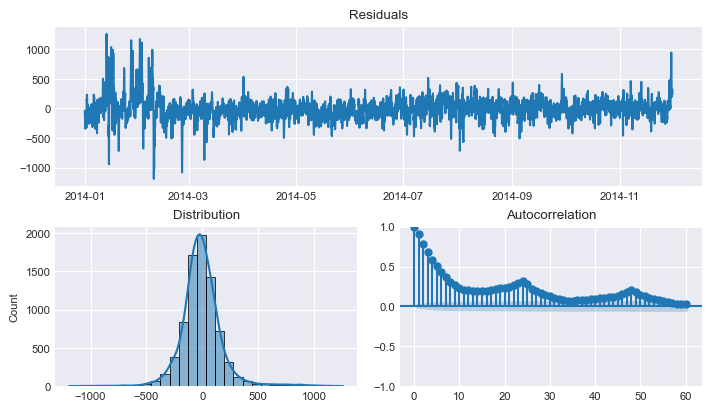

In [42]:
residuals = data.loc[predictions_val.index, 'Demand'] - predictions_val['pred']
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

Podemos ver tres gráficos:
- Residuos: Se puede observar que no hay un patrón claro por lo que no hay modelado posible de los errores.
- Distribución: Se trata de una distribución simétrica por lo que el modelo no está sesgado.
- Autocorrelación: Siguen habiendo autocorrelaciones altas en los primeros lags. Sigue existiendo información que no se está considerando.

In [43]:
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'Demand'],
    y_pred = predictions_val['pred']
)

In [44]:
cv = TimeSeriesFold(
    steps = 24, initial_train_size = len(data.loc[:end_validation]), refit = False
)
metric, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'], exog = data[exog_select], cv = cv, 
    metric = 'mean_absolute_error', interval = [5, 95], interval_method = 'conformal', use_in_sample_residuals = False, use_binned_residuals = True
)
predictions.head(5)

100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5619.156432,5145.971328,6092.341536
2014-12-01 01:00:00,5597.705961,5124.520857,6070.891065
2014-12-01 02:00:00,5622.181666,5148.996562,6095.366770
2014-12-01 03:00:00,5637.505193,5164.320089,6110.690297
2014-12-01 04:00:00,5716.909013,5243.723909,6190.094117


Pasamos a dibujar estos intervalos de predicción.

In [45]:
fig = go.Figure([
    go.Scatter(
        name='Prediccion', x=predictions.index, y=predictions['pred'], mode='lines',
    ),
    go.Scatter(
        name='Valor real', x=data_test.index, y=data_test['Demand'], mode='lines',
    ),
    go.Scatter(
        name='Límite superior', x=predictions.index, y=predictions['upper_bound'],
        mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Límite inferior', x=predictions.index, y=predictions['lower_bound'],
        marker=dict(color="#444"), line=dict(width=0), mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )
])
fig.update_layout(
    title="Valor predicho vs. reales en datos de test",
    xaxis_title="Fecha",
    yaxis_title="Demanda",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

Como se puede ver existe una linea naranja que corresponde con el valor real, una línea azul correspondiente con el valor predicho y alrededor una "sombra" gris que muestra el intervalo de predicción.

In [46]:
coverage = calculate_coverage(
    y_true = data.loc[end_validation:, "Demand"], lower_bound = predictions["lower_bound"], upper_bound = predictions["upper_bound"]
)
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Cobertura: {round(100 * coverage, 2)} %")

Cobertura: 87.64 %


La información del área total no aporta mucha información, pero la cobertura nos dice que el 87.64% de los valores reales cayeron dentro del intervalo de predicción, lo que es un dato bastante bueno y bastante similar al esperado (90%)

## Explicabilidad:

In [47]:
forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(**best_params), lags = lags_select, window_features = window_features
)
forecaster.fit(
    y = data.loc[:end_validation, 'Demand'],
    exog = data.loc[:end_validation, exog_select]
)

Obtenemos la importancia de las distintas variables del modelo.

In [48]:
feature_importances = forecaster.get_feature_importances()
feature_importances.head(10)

,feature,importance
0,lag_1,2312
53,Temperature,1257
1,lag_2,1132
5,lag_25,1070
2,lag_3,969
4,lag_24,951
3,lag_23,755
39,poly_hour_sin__hour_cos,690
47,Temperature_window_1D_mean,674
49,Temperature_window_1D_min,663


Otro método para explicar modelos son los SHAP:

In [49]:
X_train, y_train = forecaster.create_train_X_y(
    y = data_train['Demand'], exog = data_train[exog_select]
)
display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_23,lag_24,lag_25,lag_47,lag_48,lag_49,roll_mean_72,...,poly_hour_cos__sunset_hour_sin,poly_hour_cos__sunset_hour_cos,Temperature_window_1D_mean,Temperature_window_1D_max,Temperature_window_1D_min,Temperature_window_7D_mean,Temperature_window_7D_max,Temperature_window_7D_min,Temperature,Holiday
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-11 00:00:00,5087.274902,4925.770996,4661.530762,4988.975098,4963.185059,4896.571289,5039.643066,4958.630371,4886.074219,4386.356154,...,-0.707107,0.707107,16.140625,19.575001,13.175,19.321875,29.0,13.175,15.150,0.0
2012-01-11 01:00:00,5107.675781,5087.274902,4925.770996,5006.663086,4988.975098,4963.185059,5090.203125,5039.643066,4958.630371,4398.891398,...,-0.683013,0.683013,16.042707,19.575001,13.175,19.291666,29.0,13.175,15.425,0.0
2012-01-11 02:00:00,5126.337891,5107.675781,5087.274902,4977.723633,5006.663086,4988.975098,5108.837402,5090.203125,5039.643066,4410.526191,...,-0.612372,0.612372,15.939584,19.575001,13.175,19.255507,29.0,13.175,14.800,0.0


Time
2012-01-11 00:00:00    5107.675781
2012-01-11 01:00:00    5126.337891
2012-01-11 02:00:00    5103.370605
Freq: h, Name: y, dtype: float32

Al tratarse de un modelo LGBM, se debe usar el TreeExplainer.

In [50]:
shap.initjs()
explainer = shap.TreeExplainer(forecaster.regressor)

rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False) #Uso solo la mitad para acelerar el proceso
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

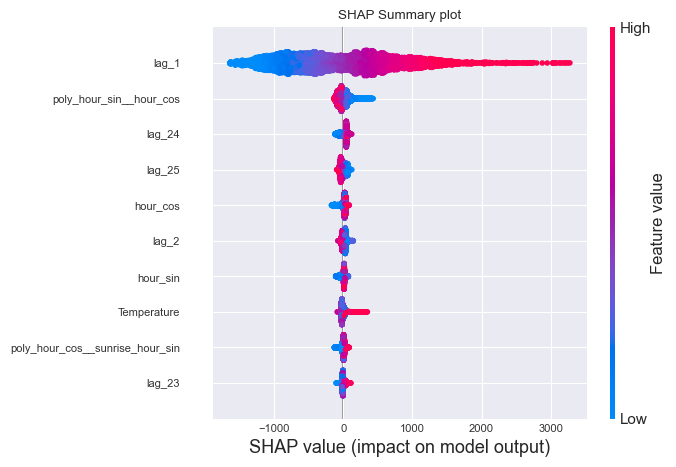

In [51]:
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

Como podemos observar, el valor de lag 1 es claramente la característica más influyente en el valor de la predicción. También se puede ver que la hora es importante y que la temperatura también pero en menor medida.

In [52]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])

## Predicción multi-step:

Hasta ahora las predicciones se han hecho de una forma recursiva. Otra opción es usar un modelo para cada una de las predicciones. Como es lógico los resultados son (o se espera que sean) mejores pero es mucho más costoso computacionalmente.

In [53]:
forecaster = ForecasterDirect(
    regressor = LGBMRegressor(**best_params), steps = 24, lags = lags_select, window_features = window_features
)

In [54]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster, y = data['Demand'], exog = data[exog_select], cv = cv, metric = 'mean_absolute_error'
)

display(metric)
predictions.head()

100%|██████████| 29/29 [00:00<00:00, 31.50it/s]


,mean_absolute_error
0,115.574252


,pred
2014-12-01 00:00:00,5633.923948
2014-12-01 01:00:00,5727.569862
2014-12-01 02:00:00,5803.980184
2014-12-01 03:00:00,6009.082995
2014-12-01 04:00:00,6238.679237


Como se ha dicho, los resultados son mucho mejores que en los casos anteriores, pero no podemos olvidar el coste que supone.

El problema de lo que se lleva hasta ahora es que es poco realista. Se estaba suponiendo que la predicción se hacía a las 11:59 PM para el día siguiente, no había tiempo de reacción.

Algo más realista sería realizar las predicciones para el día siguiente a una hora del mediodía del día anterior, por ejemplo a las 11. En este caso se debería predecir las horas restantes de ese mismo día (12) y todas las del día siguiente (24). 

In [55]:
data.iloc[:len(data.loc[:end_validation]) + 12].tail(2)

,Demand,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,sunrise_hour_sin,...,poly_sunrise_hour_cos__sunset_hour_cos,poly_sunset_hour_sin__sunset_hour_cos,Temperature_window_1D_mean,Temperature_window_1D_max,Temperature_window_1D_min,Temperature_window_7D_mean,Temperature_window_7D_max,Temperature_window_7D_min,Temperature,Holiday
Time,,,,,,,,,,,,,,,,,,,,,
2014-12-01 10:00:00,5084.011230,-2.449294e-16,1.0,-0.354605,0.935016,0.0,1.0,0.500000,-0.866025,1.0,...,3.061617e-17,-0.433013,25.589582,30.950001,20.0,18.573214,33.849998,11.15,19.90,0.0
2014-12-01 11:00:00,4851.066895,-2.449294e-16,1.0,-0.354605,0.935016,0.0,1.0,0.258819,-0.965926,1.0,...,3.061617e-17,-0.433013,25.129168,29.500000,19.9,18.601191,33.849998,11.15,19.35,0.0


In [56]:
forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(**best_params), lags = lags_select, window_features = window_features
)

cv = TimeSeriesFold(
    steps = 24, initial_train_size = len(data.loc[:end_validation]) + 12, refit = False, gap = 12,
)

metric, predictions = backtesting_forecaster(
    forecaster  = forecaster, y = data['Demand'], exog = data[exog_select], cv = cv, metric = 'mean_absolute_error'
)
display(metric)
predictions.head(5)

100%|██████████| 28/28 [00:01<00:00, 25.51it/s]


,mean_absolute_error
0,136.797966


,pred
2014-12-02 00:00:00,5405.890493
2014-12-02 01:00:00,5469.931496
2014-12-02 02:00:00,5546.926770
2014-12-02 03:00:00,5630.978336
2014-12-02 04:00:00,5773.611336


Como se puede ver las predicciones corresponden a la demanda del día siguiente al predicho.

## Conclusión:


| Modelo                          | MAE     |
|---------------------------------|---------|
| Baseline                        | 308.375 |
| LGBM Base                       | 225.521 |
| LGBM + Variables Externas       | 141.615 |
| LGBM + Selección de Parámetros  | 132.742 |
| LGBM + Feature Selection        | 131.857 |
| Multi-Step Forecasting          | 115.570 |